# libs

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from pycaret.classification import *
from wordcloud import WordCloud

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from joblib import dump, load
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# product metric

- **продукт**: чат-бот для психологической поддержки
- **задача ML**: многоклассовая классификация
- **целевая переменная**: метки эмоций
- **бизнесовая метрика**: выдвигаем гипотезу, что на RR влияет процент "хороших" эмоций к концу диалога с ботом относительно начала диалога
- **ML-метрики**: средние F-мера, AUC-ROC

**Подробнее:**

В качестве модели за основу возьмем модель ChatGPT 3.5 turbo (OpenAI), с которой будем работать через библиотеку langchain. В данной библиотеке есть класс ConversationChain который позволяет общаться с моделью имитируя общение с человеком.

Дополнительно надо добавить обработку моделью классификации, которая будет определять, в каком настроении человек, ведущий диалог с ботом. В будущем можно проводить дообучение модели на основе эмоций, которые показывали люди в текстовом виде после ответов модели.

MVP: тг-чат, который выдает ответы модели ChatGPT 3.5 + модель классификации (лучшая из autoML по F-мере и AUC-ROC), которая определяет настроение в каждой реплике человека, и сохраняет информацию по каждому юзеру в sqllite базу данных.

Термин “улучшение настроения”.
Любой разговор (коммуникация, перерывы в которой не превышают 1 час) будем делить на 4 равные части из сообщений, по первой замерять преобладающее настроение человека в момент обращения к боту, а по последней - настроение после диалога с ботом. Если процент "хороших" эмоций повышается, то значит что бот помогает справляться с тяжелым состоянием, и ожидается, что такие люди будут с большей вероятностью возвращаться к использованию продукта. 

POC: выдвигаем гипотезу, что на RR влияет “улучшение настроения”. Если в конце эксперимента пользователи с “улучшением настроения” будут иметь более высокий RR, то гипотеза подтверждена и имеет смысл дообучить модель на основе классифицированных эмоций, таким образом повысив будущее использование данного сервиса.

# data

labels:
 - 0 > sadness
 - 1 > joy
 - 2 > love
 - 3 > anger
 - 4 > fear
 - 5 > surprise

In [76]:
emotions_dict = {0:'sadness', 
                1:'joy',
                2:'love',
                3:'anger',
                4:'fear',
                5:'surprise'}

In [77]:
df_train = pd.read_csv('data/training.csv')
df_test = pd.read_csv('data/test.csv')
df_val = pd.read_csv('data/validation.csv')

In [3]:
df_train.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [70]:
df_test.text.values

array(['im feeling rather rotten so im not very ambitious right now',
       'im updating my blog because i feel shitty',
       'i never make her separate from me because i don t ever want her to feel like i m ashamed with her',
       ...,
       'i feel that i am useful to my people and that gives me a great feeling of achievement',
       'im feeling more comfortable with derby i feel as though i can start to step out my shell',
       'i feel all weird when i have to meet w people i text but like dont talk face to face w'],
      dtype=object)

In [78]:
vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)

X_train = vect.fit_transform(df_train.text.values)
X_test = vect.transform(df_test.text.values)
X_val = vect.transform(df_val.text.values)

In [5]:
X_train.shape

(16000, 15186)

In [79]:
tsvd = TruncatedSVD(n_components=1000)

X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)
X_val_pca = tsvd.transform(X_val)

In [80]:
train = pd.concat([pd.DataFrame(X_train_pca),df_train.label],axis=1)
test = pd.concat([pd.DataFrame(X_test_pca),df_test.label],axis=1)
val = pd.concat([pd.DataFrame(X_val_pca),df_val.label],axis=1)

In [8]:
# для начала обучим бейзлайн только на части данных train, чтобы быстрее понять, какую модель дальше оптимизировать

ind_0 = np.random.choice(list(df_train[df_train['label']==0].index), 2000, replace=False)
ind_1 = np.random.choice(list(df_train[df_train['label']==1].index), 2000, replace=False)
ind_3 = np.random.choice(list(df_train[df_train['label']==3].index), 2000, replace=False)

ind = list(pd.concat([df_train.iloc[ind_0],
                        df_train.iloc[ind_1],
                        df_train.iloc[ind_3],
                        df_train.query('label==4 or label==2 or label==5')]).index)

np.random.shuffle(ind)

In [10]:
new_df = df_train.iloc[ind].reset_index(drop=True)

new_vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
new_X_train = new_vect.fit_transform(new_df.text.values)

new_tsvd = TruncatedSVD(n_components=1000)
new_X_train_pca = new_tsvd.fit_transform(new_X_train)

new_train = pd.concat([pd.DataFrame(new_X_train_pca),new_df.label],axis=1)

# baseline

In [38]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [11]:
# если хотим самостоятельно задать датасеты для трейна и теста, то необходимо обеспечить чтобы у них были разные индексы строк!
# в рамках одного трейна тоже

clf = setup(data=new_train, target='label', fold=3)

,Description,Value
0,Session id,5075
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(9813, 1001)"
4,Transformed data shape,"(9813, 1001)"
5,Transformed train set shape,"(6869, 1001)"
6,Transformed test set shape,"(2944, 1001)"
7,Numeric features,1000
8,Preprocess,True
9,Imputation type,simple


In [12]:
#compare_models(include = ['ridge', 'svm', 'lr', 'qda', 'rf', 'knn', 'nb', 'dt', 'ada'])
# TT(Sec) это время на один фолд

best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8610,0.0000,0.8610,0.8619,0.8605,0.8292,0.8294,1.5733
svm,SVM - Linear Kernel,0.8559,0.0000,0.8559,0.8592,0.8553,0.8231,0.8239,2.5233
lda,Linear Discriminant Analysis,0.8557,0.9759,0.8557,0.8564,0.8556,0.8230,0.8232,6.3967
lr,Logistic Regression,0.7943,0.9628,0.7943,0.8038,0.7907,0.7458,0.7472,12.2933
lightgbm,Light Gradient Boosting Machine,0.6778,0.9184,0.6778,0.6978,0.6746,0.6008,0.6031,89.9433
xgboost,Extreme Gradient Boosting,0.6735,0.9109,0.6735,0.6886,0.6724,0.5961,0.5976,498.4700
gbc,Gradient Boosting Classifier,0.6296,0.8839,0.6296,0.6402,0.6276,0.5419,0.5435,650.4233
et,Extra Trees Classifier,0.5276,0.8175,0.5276,0.5818,0.5088,0.4103,0.4155,7.5567
rf,Random Forest Classifier,0.5168,0.8082,0.5168,0.5701,0.4996,0.3969,0.4017,14.3100
nb,Naive Bayes,0.4168,0.7162,0.4168,0.4351,0.4166,0.2856,0.2885,1.6967


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Ridge Classifier is the best baseline model, but it doesn't have predict_proba attribute (that's why AUC-ROC=0)

So we should use Linear Discriminant Analysis model instead

Or we can add probabilities to [Ridge](https://stackoverflow.com/questions/22538080/scikit-learn-ridge-classifier-extracting-class-probabilities) or [SVM](https://koalatea.io/sklearn-svm-predicted-probabilites/)

In [13]:
best

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize='deprecated', positive=False,
                random_state=5075, solver='auto', tol=0.001)

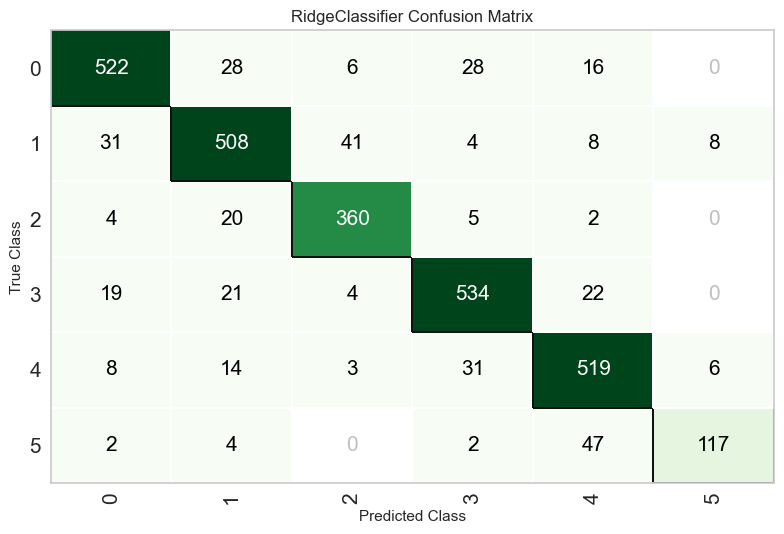

In [14]:
plot_model(best, plot = 'confusion_matrix')

# LDA

In [56]:
model = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

roc_auc = make_scorer(roc_auc_score, multi_class='ovo', average='macro', needs_proba=True)
f1 = make_scorer(f1_score, average='macro')

scoring = {'auc': roc_auc,
           'f1': f1}

scores = cross_validate(model, X_train_pca, df_train.label, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean AUC-ROC: %.2f (%.3f)\nMean F1: %.2f (%.3f)' % (np.mean(scores['test_auc']), np.std(scores['test_auc']),
                                                np.mean(scores['test_f1']), np.std(scores['test_f1'])))

Mean AUC-ROC: 0.98 (0.001) 
Mean F1: 0.84 (0.002)


т.к. нам важны все классы, в том числе в которых меньше объектов, то возьмем макро усреднение (макроусреднение более чувствительно к качеству классификации маломощных классов)

по метрикам качества видно, что все классы предсказываются довольно хорошо

обучим теперь модель по всем данным train, и измерим качество на test (val пригодится потом, т.к. по test будем измерять качество между разными моделями, а по val определять итоговое качество выбранной модели)

In [81]:
model = LinearDiscriminantAnalysis()
model.fit(X_train_pca, df_train.label)

print('Test AUC-ROC: %.2f\nTest F1: %.2f' % 
      (roc_auc_score(y_true=df_test.label, y_score=model.predict_proba(X_test_pca), multi_class='ovo', average='macro'), 
       f1_score(y_true=df_test.label, y_pred=model.predict(X_test_pca), average='macro') 
      ))

Test AUC-ROC: 0.98
Test F1: 0.83


In [84]:
dump(model, 'models/LDA_clf.joblib') 

['LDA_clf.joblib']

In [82]:
[emotions_dict[x] for x in model.predict(tsvd.transform(vect.transform(
            np.array(['i feel quite optimistic about it', 
                      'i am hurt and lost',
                      'what if everyone would be better without me',
                     'im afraid of the future'])
             )))]

['joy', 'sadness', 'joy', 'fear']

In [113]:
clf = load('models/LDA_clf.joblib') 

[emotions_dict[x] for x in clf.predict(tsvd.transform(vect.transform(
            np.array(['i feel quite optimistic about it', 
                      'i am hurt and lost',
                      'what if everyone would be better without me',
                     'im afraid of the future'])
             )))]

['joy', 'sadness', 'joy', 'fear']

хоть качество и высокое, но определенно надо добавить n-граммы (хотя бы из 2-3 слов)

In [9]:
pd.DataFrame(X_train.toarray(), 
                 columns=vect.get_feature_names()).head()

,aa,aaaaaaand,aaaaand,aaaand,aac,aahhh,aaron,ab,abandon,abandoned,...,zonisamide,zoo,zoom,zooming,zooms,zq,zucchini,zum,zumba,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


также стоит добавить стоп-слова, и попробовать преобразовать оставшиеся в корни слов, или хотя бы добавить их как доп признаки (Стеммизация/Лемматизация)

## visualize WordCloud

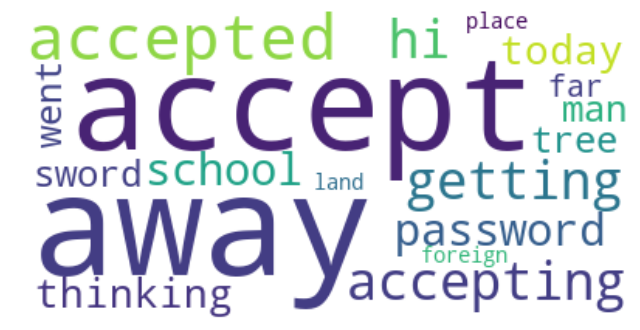

In [10]:
# пример изображения облака слов

corpus = ['Hi what are you accepting here do you accept me',
'What are you thinking about getting today',
'Give me your password to get accepted into this school',
'The man went to the tree to get his sword back',
'go away to a far away place in a foreign land']

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))

plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")

# store to file
#plt.savefig("img/por_wine.png", format="png")

plt.show()

In [ ]:
# нужно много времени, но позволит вывести красиво самые влияющие 50 токенов 
# логичнее запускать когда будут разные модели, также для сравнения


df_tokens = pd.DataFrame(X_train.todense().tolist(), 
                 columns=vect.get_feature_names())

Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df_tokens.T.sum(axis=1))
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# chat models test

## BLOOMZ

In [1]:
import torch
from transformers import BloomTokenizerFast 
from petals import DistributedBloomForCausalLM

ModuleNotFoundError: No module named 'petals'

In [14]:
pip install petals

     -------------------------------------- 87.1/87.1 kB 492.8 kB/s eta 0:00:00
  Using cached tensor_parallel-1.0.23-py3-none-any.whl (25 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
     ------------------------------------ 219.1/219.1 kB 478.0 kB/s eta 0:00:00
  Using cached bitsandbytes-0.38.0.post2-py3-none-any.whl (98.2 MB)
  Using cached cpufeature-0.2.1-cp39-cp39-win_amd64.whl (15 kB)
     ---------------------------------------- 9.2/9.2 MB 1.6 MB/s eta 0:00:00
  Using cached speedtest_cli-2.1.3-py2.py3-none-any.whl (23 kB)
  Using cached protobuf-3.20.3-cp39-cp39-win_amd64.whl (904 kB)
     ---------------------------------------- 2.0/2.0 MB 1.4 MB/s eta 0:00:00
  Using cached ConfigArgParse-1.5.3-py3-none-any.whl (20 kB)
  Using cached pydantic-1.10.7-cp39-cp39-win_amd64.whl (2.2 MB)
  Using cached prefetch_generator-1.0.3.tar.gz (4.6 kB)
  Preparing metadata (setup.py): started
  Preparing met

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\anya9\AppData\Local\Temp\pip-install-vu4xe3pe\uvloop_6febc9f39c7e44d093fc007aca8b2681\setup.py", line 8, in <module>
      raise RuntimeError('uvloop does not support Windows at the moment')
  RuntimeError: uvloop does not support Windows at the moment
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
MODEL_NAME = "bigscience/bloom-petals"
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_NAME)
model = DistributedBloomForCausalLM.from_pretrained(MODEL_NAME)
model = model.cuda()

In [2]:
!nvidia-smi

"nvidia-smi" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## ChatGPT 3.5 turbo (OpenAI)

In [ ]:
# Однако у данной модели ограничение для бесплатного пользования 3 запроса в минуту!
# Так что в перспективе лучше перейти на линукс/коллаб и поставить BLOOMZ

In [9]:
from langchain.chains import ConversationChain
from langchain.chains.conversation.memory import ConversationEntityMemory
from langchain.chains.conversation.prompt import ENTITY_MEMORY_CONVERSATION_TEMPLATE
from langchain.chat_models import ChatOpenAI

import sys
sys.path.append('../../../jupyter/')

# my credentials
from CREDS import *

In [14]:
API_O = api()

#['gpt-3.5-turbo','text-davinci-003','text-davinci-002','code-davinci-002']
MODEL = 'gpt-3.5-turbo'

# Summary of prompts to consider (min_value=3,max_value=1000)
K = 1000

In [15]:
llm = ChatOpenAI(temperature=0,
            openai_api_key=API_O, 
            model_name=MODEL, 
            verbose=False) 

In [16]:
# Create the ConversationChain object with the specified configuration
Conversation = ConversationChain(
        llm=llm, 
        prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
        memory=ConversationEntityMemory(llm=llm, k=K)
    )  

In [166]:
output = Conversation.run(input='what can I do to feel better') 
output

"There are many things you can do to feel better, depending on what specifically is bothering you. Can you provide me with more information about what's going on so I can provide more specific advice?"

In [168]:
all_convos={}

all_convos[112] = ConversationChain(
                                    llm=llm, 
                                    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
                                    memory=ConversationEntityMemory(llm=llm, k=K)
                                    )  

all_convos[345] = ConversationChain(
                                    llm=llm, 
                                    prompt=ENTITY_MEMORY_CONVERSATION_TEMPLATE,
                                    memory=ConversationEntityMemory(llm=llm, k=K)
                                    )  

In [175]:
import time

In [185]:
all_convos[112].run(input='my name is Katya')
time.sleep(60)
all_convos[345].run(input='my name is Sveta')
time.sleep(60)

print(all_convos[112].run(input='do you know my name?')) 
time.sleep(60)
print(all_convos[345].run(input='do you know my name?'))

Yes, your name is Katya. Is there anything else you would like me to help you with?
Yes, your name is Sveta. Is there anything else I can help you with?


In [ ]:
# видим что таким образом сохраняется история общения с каждым юзером по отдельности

## bot real-time analytics

In [199]:
# users per day

import json
with open('bot_data/arr_discs.json') as user_file:
    dict_discs = json.load(user_file)

import pandas as pd
all_comm = pd.DataFrame([sum([x.split('_'), [len(dict_discs[x])]],[]) for x in list(dict_discs.keys())], columns=['users','time','num_mess'])
all_comm['time'] = all_comm.apply(lambda x: datetime.datetime.fromtimestamp(int(x['time'])), axis=1)
all_comm = all_comm.query('users!="316527246"')
df_pivot = all_comm.pivot_table('num_mess', index='users', columns='time', aggfunc='sum', fill_value='', margins=True)
df_pivot = df_pivot.reindex(df_pivot['All'].sort_values(ascending=False).index)
df_pivot.columns = [str(x).split(" ")[0] for x in df_pivot.columns]
df_pivot

,2023-05-24,2023-05-25,All
users,,,
All,7,18,25
403129119,,8.0,8
350622783,,5.0,5
399243118,5.0,,5
245621453,,4.0,4
142891339,2.0,,2
509652800,,1.0,1
344809905,,0.0,0


In [200]:
# какое самое недавнее сообщение по МСК (чтоб не прерывать диалоги, если надо перезагрузить)

import json
with open('bot_data/arr_discs.json') as user_file:
    dict_discs = json.load(user_file)

import datetime
max_datetime = 0
for key in dict_discs.keys():
    try: 
        curr_max = np.max([x[2] for x in dict_discs[key]])
    except:
        curr_max = 0
    max_datetime = curr_max if max_datetime < curr_max else max_datetime
str(datetime.datetime.fromtimestamp(max_datetime) + datetime.timedelta(hours=3))

'2023-05-25 11:35:23'